In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

import json
import gzip
import pickle
import datetime

from collections import defaultdict
from scipy.spatial.distance import hamming
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
dataset_list = ['yeast', 'woman'] #, 'diabete']
blackbox_list = ['rf', 'svm', 'mlp']

In [3]:
hit_gdt = defaultdict(lambda: defaultdict(list))
rules_gdt = defaultdict(lambda: defaultdict(list))
gdt_labels = defaultdict(lambda: defaultdict(list))

for dataset in dataset_list:
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list:
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../global_dt/GDT_to_mimic_%s_%s_metrics.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            #saving hit
            hit_gdt[dataset_name][bb_name].append(1.0 - r['hit_sm'])
            #saving rule lenght
            rules_gdt[dataset_name][bb_name].append(r['len_rule'])
            #saving label
            gdt_labels[dataset][bb_name].append(r['i2e_GDT_label'])
            
        resfile.close()

2018-11-04 18:52:30.454559 dataset: yeast
2018-11-04 18:52:30.454660 blackbox: rf
2018-11-04 18:52:30.493450 blackbox: svm
2018-11-04 18:52:30.526205 blackbox: mlp
2018-11-04 18:52:30.556077 dataset: woman
2018-11-04 18:52:30.556153 blackbox: rf
2018-11-04 18:52:30.719458 blackbox: svm
2018-11-04 18:52:30.880775 blackbox: mlp


### Comparison between mixed and union approaches

In [4]:
output_files = []
names_output = listdir('../output/')
for name in names_output:
    if name.startswith('20181103'):
        output_files.append(name)
output_files

['20181103_0226_yeast_rf_explanationsandmetrics.json.gz',
 '20181103_0228_woman_rf_explanationsandmetrics.json.gz',
 '20181103_0228_woman_svm_explanationsandmetrics.json.gz',
 '20181103_0226_yeast_svm_explanationsandmetrics.json.gz',
 '20181103_0227_yeast_mlp_explanationsandmetrics.json.gz',
 '20181103_0229_woman_mlp_explanationsandmetrics.json.gz']

In [5]:
mixed_fidelity_sn = defaultdict(list)
mixed_fidelity_rn = defaultdict(list)
union_fidelity_sn = defaultdict(list)
union_fidelity_rn = defaultdict(list)

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']

            mixed_fidelity_sn[bb_name].append(r['fidelity_tree1_syn'])
            mixed_fidelity_rn[bb_name].append(r['fidelity_tree1_kNN'])

            union_fidelity_sn[bb_name].append(r['fidelity_tree2_syn'])
            union_fidelity_rn[bb_name].append(r['fidelity_tree2_kNN'])

        resfile.close()

2018-11-04 18:52:31.066008 dataset: yeast
2018-11-04 18:52:31.066207 blackbox: rf
2018-11-04 18:52:31.105530 blackbox: svm
2018-11-04 18:52:31.141481 blackbox: mlp
2018-11-04 18:52:31.175505 dataset: woman
2018-11-04 18:52:31.175542 blackbox: rf
2018-11-04 18:52:31.386771 blackbox: svm
2018-11-04 18:52:31.598149 blackbox: mlp


In [6]:
values = []
print('Table 2')
for bb_name in blackbox_list:
    print(bb_name)
    print('\tmixed fidelity sn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_sn[bb_name]), np.std(mixed_fidelity_sn[bb_name])))
    values.append(np.mean(mixed_fidelity_sn[bb_name]))
    values.append(np.std(mixed_fidelity_sn[bb_name]))            
    print('\tunion fidelity sn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_sn[bb_name]), np.std(union_fidelity_sn[bb_name])))
    values.append(np.mean(union_fidelity_sn[bb_name]))
    values.append(np.std(union_fidelity_sn[bb_name]))
    print('---')
    print('\tmixed fidelity rn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_rn[bb_name]), np.std(mixed_fidelity_rn[bb_name])))
    values.append(np.mean(mixed_fidelity_rn[bb_name]))
    values.append(np.std(mixed_fidelity_rn[bb_name]))
    print('\tunion fidelity rn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_rn[bb_name]), np.std(union_fidelity_rn[bb_name])))
    values.append(np.mean(union_fidelity_rn[bb_name]))
    values.append(np.std(union_fidelity_rn[bb_name]))

Table 2
rf
	mixed fidelity sn: 0.939 \pm 0.021
	union fidelity sn: 0.902 \pm 0.047
---
	mixed fidelity rn: 0.888 \pm 0.091
	union fidelity rn: 0.870 \pm 0.110
svm
	mixed fidelity sn: 0.909 \pm 0.045
	union fidelity sn: 0.879 \pm 0.059
---
	mixed fidelity rn: 0.594 \pm 0.209
	union fidelity rn: 0.606 \pm 0.232
mlp
	mixed fidelity sn: 0.947 \pm 0.032
	union fidelity sn: 0.938 \pm 0.045
---
	mixed fidelity rn: 0.613 \pm 0.266
	union fidelity rn: 0.619 \pm 0.245


In [7]:
print(r"""
\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{union} & \textit{mixed} & \textit{union} \\
 \hline
\textit{RF}  & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{union} approaches: averages and standard deviations of fidelity measures on the synthetic neighborhood \textit{s-fidelity} and on the neighborhood of real data points used to generate the synthetic one \textit{r-fidelity}.}
\label{tab:neigh_comp}
\end{table}
""" % tuple(values))


\begin{table}[h]
\vspace{2mm}
\centering
\setlength{\tabcolsep}{1.5mm}
\small
\begin{tabular}{|c|cc|cc|}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{\textit{s-fidelity}} & \multicolumn{2}{c|}{\textit{r-fidelity}} \\
 & \textit{mixed} & \textit{union} & \textit{mixed} & \textit{union} \\
 \hline
\textit{RF}  & 0.94 $\pm$ 0.02 & 0.90 $\pm$ 0.05 & 0.89 $\pm$ 0.09 & 0.87 $\pm$ 0.11 \\
\textit{SVM} & 0.91 $\pm$ 0.04 & 0.88 $\pm$ 0.06 & 0.59 $\pm$ 0.21 & 0.61 $\pm$ 0.23 \\
\textit{MLP} & 0.95 $\pm$ 0.03 & 0.94 $\pm$ 0.05 & 0.61 $\pm$ 0.27 & 0.62 $\pm$ 0.24 \\
\hline
\end{tabular}
\caption{Comparison between \emph{mixed} and \emph{union} approaches: averages and standard deviations of fidelity measures on the synthetic neighborhood \textit{s-fidelity} and on the neighborhood of real data points used to generate the synthetic one \textit{r-fidelity}.}
\label{tab:neigh_comp}
\end{table}



## Hit performances MARLENA vs GDT

In [8]:
#saving hit values for MARLENA (both mixed and union)
hit_mixed = defaultdict(lambda: defaultdict(list))
hit_union = defaultdict(lambda: defaultdict(list))

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']

            hit_mixed[dataset_name][bb_name].append(1.0 - r['hit_sm_tree1'])
            hit_union[dataset_name][bb_name].append(1.0 - r['hit_sm_tree2'])

        resfile.close()

2018-11-04 18:52:31.843698 dataset: yeast
2018-11-04 18:52:31.843799 blackbox: rf
2018-11-04 18:52:31.882654 blackbox: svm
2018-11-04 18:52:31.918967 blackbox: mlp
2018-11-04 18:52:31.954025 dataset: woman
2018-11-04 18:52:31.954074 blackbox: rf
2018-11-04 18:52:32.163988 blackbox: svm
2018-11-04 18:52:32.376055 blackbox: mlp


Table 3 e plot-MIXED
yeast
	 rf
		hit MARLENA 0.973 pm 0.046
		hit GDT 0.982 pm 0.037
	 svm
		hit MARLENA 0.949 pm 0.062
		hit GDT 0.932 pm 0.067
	 mlp
		hit MARLENA 0.970 pm 0.048
		hit GDT 0.942 pm 0.066
woman
	 rf
		hit MARLENA 0.951 pm 0.065
		hit GDT 0.985 pm 0.036
	 svm
		hit MARLENA 0.864 pm 0.093
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.804 pm 0.147
		hit GDT 0.988 pm 0.034


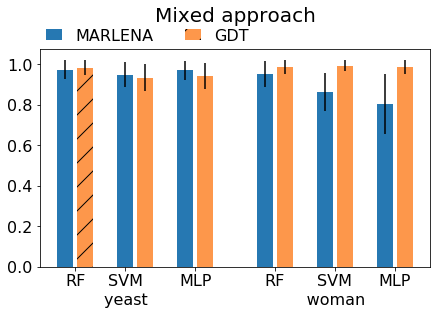

In [9]:
print('Table 3 e plot-MIXED')
values_hit = []
plt.figure(figsize=(7,4))
index = 0
for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit_mixed[dataset_name][bb_name]), np.std(hit_mixed[dataset_name][bb_name])))
        values_hit.append(np.mean(hit_mixed[dataset_name][bb_name]))
        values_hit.append(np.std(hit_mixed[dataset_name][bb_name]))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_mixed[dataset_name][bb_name]), 
                    yerr=np.std(hit_mixed[dataset_name][bb_name]), color='#2678b2', label='MARLENA')
        else:
            plt.bar(index, np.mean(hit_mixed[dataset_name][bb_name]), 
                    yerr=np.std(hit_mixed[dataset_name][bb_name]), color='#2678b2')
        index += 1
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        values_hit.append(np.mean(hit_gdt[dataset_name][bb_name]))
        values_hit.append(np.std(hit_gdt[dataset_name][bb_name]))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label='GDT', hatch='/')
        else:
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b')
        index +=2
    index += 1
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5], ['RF', 'SVM', 'MLP']*2)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.title('Mixed approach',fontsize=20,y=1.10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                               woman', fontsize=16)
plt.savefig('../fig/MIXED_barplot.png', format='png', bbox_inches='tight')
plt.show()

In [10]:
print(r"""\begin{table}[t]
\vspace{2mm}
\setlength{\tabcolsep}{1mm}
\centering
\small
\begin{tabular}{|c|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{\textit{yeast}} & \multicolumn{2}{c|}{\textit{woman}} \\
\hline
\textit{Black Box} & MARLENA & GDT & MARLENA & GDT \\
\hline
\textit{RF} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\hline
\end{tabular}
\caption{Hit performance comparison between MARLENA \textbf{mixed-approach} and a global decision tree (GDT) trained directly on the dataset containing the instances to be explained.}
\label{tab:hit_mixed}
\end{table}""" % tuple(values_hit))

\begin{table}[t]
\vspace{2mm}
\setlength{\tabcolsep}{1mm}
\centering
\small
\begin{tabular}{|c|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{\textit{yeast}} & \multicolumn{2}{c|}{\textit{woman}} \\
\hline
\textit{Black Box} & MARLENA & GDT & MARLENA & GDT \\
\hline
\textit{RF} & 0.97 $\pm$ 0.05 & 0.98 $\pm$ 0.04 & 0.95 $\pm$ 0.06 & 0.93 $\pm$ 0.07 \\
\textit{SVM} & 0.97 $\pm$ 0.05 & 0.94 $\pm$ 0.07 & 0.95 $\pm$ 0.06 & 0.99 $\pm$ 0.04 \\
\textit{MLP} & 0.86 $\pm$ 0.09 & 0.99 $\pm$ 0.03 & 0.80 $\pm$ 0.15 & 0.99 $\pm$ 0.03 \\
\hline
\end{tabular}
\caption{Hit performance comparison between MARLENA \textbf{mixed-approach} and a global decision tree (GDT) trained directly on the dataset containing the instances to be explained.}
\label{tab:hit_mixed}
\end{table}


Table 3 e plot-UNION
yeast
	 rf
		hit MARLENA 0.969 pm 0.047
		hit GDT 0.982 pm 0.037
	 svm
		hit MARLENA 0.948 pm 0.061
		hit GDT 0.932 pm 0.067
	 mlp
		hit MARLENA 0.965 pm 0.052
		hit GDT 0.942 pm 0.066
woman
	 rf
		hit MARLENA 0.942 pm 0.066
		hit GDT 0.985 pm 0.036
	 svm
		hit MARLENA 0.868 pm 0.094
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.797 pm 0.124
		hit GDT 0.988 pm 0.034


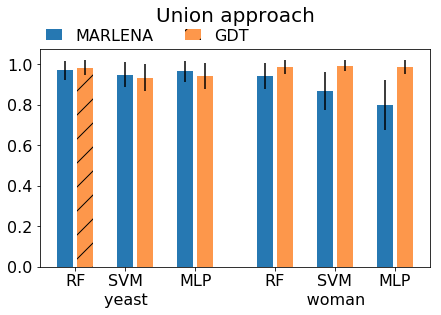

\begin{table}[t]
\vspace{2mm}
\setlength{\tabcolsep}{1mm}
\centering
\small
\begin{tabular}{|c|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{\textit{yeast}} & \multicolumn{2}{c|}{\textit{woman}} \\
\hline
\textit{Black Box} & MARLENA & GDT & MARLENA & GDT \\
\hline
\textit{RF} & 0.97 $\pm$ 0.05 & 0.98 $\pm$ 0.04 & 0.95 $\pm$ 0.06 & 0.93 $\pm$ 0.07 \\
\textit{SVM} & 0.96 $\pm$ 0.05 & 0.94 $\pm$ 0.07 & 0.94 $\pm$ 0.07 & 0.99 $\pm$ 0.04 \\
\textit{MLP} & 0.87 $\pm$ 0.09 & 0.99 $\pm$ 0.03 & 0.80 $\pm$ 0.12 & 0.99 $\pm$ 0.03 \\
\hline
\end{tabular}
\caption{Hit performance comparison between MARLENA \textbf{unified-approach} and a global decision tree (GDT) trained directly on the dataset containing the instances to be explained.}
\label{tab:hit_union}
\end{table}


In [11]:
print('Table 3 e plot-UNION')
values_hit = []

plt.figure(figsize=(7,4))
index = 0
for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit_union[dataset_name][bb_name]), np.std(hit_union[dataset_name][bb_name])))
        values_hit.append(np.mean(hit_union[dataset_name][bb_name]))
        values_hit.append(np.std(hit_union[dataset_name][bb_name]))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_union[dataset_name][bb_name]), 
                    yerr=np.std(hit_union[dataset_name][bb_name]), color='#2678b2', label='MARLENA')
        else:
            plt.bar(index, np.mean(hit_union[dataset_name][bb_name]), 
                    yerr=np.std(hit_union[dataset_name][bb_name]), color='#2678b2')
        index += 1
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        values_hit.append(np.mean(hit_gdt[dataset_name][bb_name]))
        values_hit.append(np.std(hit_gdt[dataset_name][bb_name]))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label='GDT', hatch='/')
        else:
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b')
        index +=2
    index += 1
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5], ['RF', 'SVM', 'MLP']*2)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.title('Union approach',fontsize=20,y=1.10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                               woman', fontsize=16)
plt.savefig('../fig/UNION_barplot.png', format='png', bbox_inches='tight')
plt.show()



print(r"""\begin{table}[t]
\vspace{2mm}
\setlength{\tabcolsep}{1mm}
\centering
\small
\begin{tabular}{|c|cc|cc|}
\hline
\textit{Dataset} & \multicolumn{2}{c|}{\textit{yeast}} & \multicolumn{2}{c|}{\textit{woman}} \\
\hline
\textit{Black Box} & MARLENA & GDT & MARLENA & GDT \\
\hline
\textit{RF} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{MLP} & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\hline
\end{tabular}
\caption{Hit performance comparison between MARLENA \textbf{unified-approach} and a global decision tree (GDT) trained directly on the dataset containing the instances to be explained.}
\label{tab:hit_union}
\end{table}""" % tuple(values_hit))

## Fidelities performances on interesting classes: MARLENA vs GDT

In [12]:
bb_labels = defaultdict(lambda: defaultdict(list))
mixed_marlena_labels = defaultdict(lambda: defaultdict(list))
union_marlena_labels = defaultdict(lambda: defaultdict(list))
mixed_marlena_rule_lenght = defaultdict(lambda: defaultdict(list))
union_marlena_rule_lenght = defaultdict(lambda: defaultdict(list))


for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            bb_labels[dataset_name][bb_name].append(r['i2e_bb_label'])
            mixed_marlena_labels[dataset_name][bb_name].append(r['i2e_tree1_label']) 
            union_marlena_labels[dataset_name][bb_name].append(r['i2e_tree2_label']) 
            mixed_marlena_rule_lenght[dataset_name][bb_name].append(r['lenght_rule_tree1'])
            union_marlena_rule_lenght[dataset_name][bb_name].append(r['lenght_rule_tree2'])
        resfile.close()

2018-11-04 18:52:33.211699 dataset: yeast
2018-11-04 18:52:33.211931 blackbox: rf
2018-11-04 18:52:33.257292 blackbox: svm
2018-11-04 18:52:33.296997 blackbox: mlp
2018-11-04 18:52:33.332919 dataset: woman
2018-11-04 18:52:33.332957 blackbox: rf
2018-11-04 18:52:33.546749 blackbox: svm
2018-11-04 18:52:33.762701 blackbox: mlp


In [13]:
print('Table 4 - MIXED')

for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        bl = np.asarray(bb_labels[dataset][bb_name])
        ml = np.asarray(mixed_marlena_labels[dataset][bb_name])
        nbr_instances = len(bl)
        gl = np.asarray(gdt_labels[dataset][bb_name][:nbr_instances])

        f1score_marlena = f1_score(bl, ml, average=None)
        f1score_gdt = f1_score(bl, gl, average=None)

        marlena_values = list()
        gdt_values = list()
        for i in range(0, len(bl[0])):
            #qui faccio solo la media e la deviazione standard per le features che sono interessanti,
            #ovvero quelle che non sono tutte 0 o tutte 1 
            flag = 0 < np.sum(bl[:,i])/len(bl) < 1
            if flag:
                marlena_values.append(f1score_marlena[i])
                gdt_values.append(f1score_gdt[i])

        print('MARLENA: avg %.3f, std %.3f, median %.3f' % (
            np.mean(marlena_values), np.std(marlena_values), np.median(marlena_values)))
        print('GDT:\t avg %.3f, std %.3f, median %.3f' % (
            np.mean(gdt_values), np.std(gdt_values), np.median(gdt_values)))
    print('')

Table 4 - MIXED
yeast
	 rf
MARLENA: avg 0.525, std 0.405, median 0.750
GDT:	 avg 0.795, std 0.271, median 0.881
	 svm
MARLENA: avg 0.618, std 0.357, median 0.764
GDT:	 avg 0.544, std 0.356, median 0.631
	 mlp
MARLENA: avg 0.890, std 0.078, median 0.897
GDT:	 avg 0.771, std 0.168, median 0.766

woman
	 rf
MARLENA: avg 0.410, std 0.391, median 0.504
GDT:	 avg 0.653, std 0.378, median 0.831
	 svm
MARLENA: avg 0.175, std 0.277, median 0.041
GDT:	 avg 0.793, std 0.288, median 0.893
	 mlp
MARLENA: avg 0.260, std 0.319, median 0.022
GDT:	 avg 0.612, std 0.374, median 0.704



/home/user/venvs/LORE_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/venvs/LORE_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [14]:
print('Table 4 - UNION')

for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        bl = np.asarray(bb_labels[dataset][bb_name])
        ml = np.asarray(union_marlena_labels[dataset][bb_name])
        nbr_instances = len(bl)
        gl = np.asarray(gdt_labels[dataset][bb_name][:nbr_instances])

        f1score_marlena = f1_score(bl, ml, average=None)
        f1score_gdt = f1_score(bl, gl, average=None)

        marlena_values = list()
        gdt_values = list()
        for i in range(0, len(bl[0])):
            flag = 0 < np.sum(bl[:,i])/len(bl) < 1
            if flag:
                marlena_values.append(f1score_marlena[i])
                gdt_values.append(f1score_gdt[i])

        print('MARLENA: avg %.3f, std %.3f, median %.3f' % (
            np.mean(marlena_values), np.std(marlena_values), np.median(marlena_values)))
        print('GDT:\t avg %.3f, std %.3f, median %.3f' % (
            np.mean(gdt_values), np.std(gdt_values), np.median(gdt_values)))
    print('')

Table 4 - UNION
yeast
	 rf
MARLENA: avg 0.546, std 0.377, median 0.681
GDT:	 avg 0.795, std 0.271, median 0.881
	 svm
MARLENA: avg 0.617, std 0.353, median 0.755
GDT:	 avg 0.544, std 0.356, median 0.631
	 mlp
MARLENA: avg 0.880, std 0.074, median 0.873
GDT:	 avg 0.771, std 0.168, median 0.766

woman
	 rf
MARLENA: avg 0.380, std 0.381, median 0.382
GDT:	 avg 0.653, std 0.378, median 0.831
	 svm
MARLENA: avg 0.166, std 0.278, median 0.055
GDT:	 avg 0.793, std 0.288, median 0.893
	 mlp
MARLENA: avg 0.263, std 0.328, median 0.025
GDT:	 avg 0.612, std 0.374, median 0.704



# Measures of rule lenght for the GDT

In [15]:
rule_len_values = []
for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        
        print('\t', bb_name)
        mixed_mr = np.asarray(mixed_marlena_rule_lenght[dataset][bb_name])
        union_mr = np.asarray(union_marlena_rule_lenght[dataset][bb_name])
        gdt_mr = np.asarray(list(map(int, rules_gdt[dataset][bb_name])))
        
        print('MARLENA: mixed mean rule lenght\t %.2f pm %.2f' % (np.mean(mixed_mr),np.std(mixed_mr)))
        rule_len_values.append(np.mean(mixed_mr))
        rule_len_values.append(np.std(mixed_mr))
        print('MARLENA: union mean rule lenght\t %.2f pm %.2f' % (np.mean(union_mr),np.std(union_mr)))
        rule_len_values.append(np.mean(union_mr))
        rule_len_values.append(np.std(union_mr))
        print('GDT: mean rule lenght\t\t %.2f pm %.2f' % (np.mean(gdt_mr),np.std(gdt_mr)))
        rule_len_values.append(np.mean(gdt_mr))
        rule_len_values.append(np.std(gdt_mr))

    print('')
    
    
print(r"""\begin{table}[h]
\setlength{\tabcolsep}{2mm}
\centering
\small
\begin{tabular}{|c|lll|lll|}
\hline
\textit{Dataset} & \multicolumn{3}{c|}{\textit{yeast}} \\ \hline
\textit{Approach} & \multicolumn{2}{c}{MARLENA} & \multicolumn{1}{c|}{GDT} \\ \hline
\multicolumn{1}{|l|}{\textit{Black Box}} & \textit{mixed} & \textit{unified} &   \\ \hline
\textit{RF} &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f & %.2f $\pm$ %.2f \\
\textit{SVM} &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f \\
\textit{MLP} &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f  \\ \hline


\textit{Dataset} & \multicolumn{3}{c|}{\textit{woman}} \\ \hline
\textit{Approach} & \multicolumn{2}{c}{MARLENA} & \multicolumn{1}{c|}{GDT} \\ \hline
\multicolumn{1}{|l|}{\textit{Black Box}} & \textit{mixed} & \textit{unified} &   \\ \hline
\textit{RF} &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f \\
\textit{SVM} &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f  \\
\textit{MLP} &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f &  %.2f $\pm$ %.2f \\ \hline

\end{tabular}
\caption{Rule lenght comparison among all the approaches}
\label{tab:rule_len}
\end{table}""" % tuple(rule_len_values))

yeast
	 rf
MARLENA: mixed mean rule lenght	 2.92 pm 2.27
MARLENA: union mean rule lenght	 2.91 pm 2.44
GDT: mean rule lenght		 9.09 pm 3.35
	 svm
MARLENA: mixed mean rule lenght	 3.29 pm 2.24
MARLENA: union mean rule lenght	 3.18 pm 1.99
GDT: mean rule lenght		 5.68 pm 1.47
	 mlp
MARLENA: mixed mean rule lenght	 2.44 pm 1.99
MARLENA: union mean rule lenght	 2.70 pm 2.30
GDT: mean rule lenght		 6.70 pm 2.36

woman
	 rf
MARLENA: mixed mean rule lenght	 4.30 pm 0.98
MARLENA: union mean rule lenght	 4.36 pm 1.19
GDT: mean rule lenght		 13.20 pm 4.56
	 svm
MARLENA: mixed mean rule lenght	 4.31 pm 1.51
MARLENA: union mean rule lenght	 4.36 pm 1.62
GDT: mean rule lenght		 16.30 pm 6.61
	 mlp
MARLENA: mixed mean rule lenght	 2.93 pm 1.17
MARLENA: union mean rule lenght	 2.77 pm 1.42
GDT: mean rule lenght		 14.85 pm 6.17

\begin{table}[h]
\setlength{\tabcolsep}{2mm}
\centering
\small
\begin{tabular}{|c|lll|lll|}
\hline
\textit{Dataset} & \multicolumn{3}{c|}{\textit{yeast}} \\ \hline
\textit{App